In [1]:
!pip install tqdm==4.19.9
!pip install shapely
!pip install imutils

import cv2
import math
import os
import sys
import time
import numpy as np
import skimage.io
from skimage.transform import rescale, resize, downscale_local_mean
from skimage.measure import label, regionprops

from scipy.spatial import distance

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pycocotools import mask as maskUtils

import coco #a slightly modified version

from mrcnn.evaluate import build_coco_results, evaluate_coco
from mrcnn.dataset import MappingChallengeDataset
from mrcnn import visualize


import zipfile
import urllib.request
import shutil
import glob
import tqdm
import random
from matplotlib import pyplot as plt
import imutils

import shapely
from shapely.geometry import LineString, Point

from pycocotools.coco import COCO

ROOT_DIR = os.getcwd()

    100% |################################| 61kB 522kB/s ta 0:00:01
You are using pip version 18.1, however version 20.3.4 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |################################| 1.0MB 5.4MB/s ta 0:00:011
You are using pip version 18.1, however version 20.3.4 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
  Running setup.py bdist_wheel for imutils ... done
  Stored in directory: /root/.cache/pip/wheels/db/23/45/fc7424906880ffa9577a2a428b961f2b79e0e21d9f71e7e6bc
Successfully built imutils
You are using pip version 18.1, however version 20.3.4 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


Using TensorFlow backend.


# Initialization

In [2]:
ROOT_DIR = os.getcwd()

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import model as modellib, utils


PRETRAINED_MODEL_PATH = os.path.join(ROOT_DIR,"data/" "pretrained_weights.h5")
LOGS_DIRECTORY = os.path.join(ROOT_DIR, "logs")
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
IMAGE_DIR = os.path.join(ROOT_DIR, "data", "test", "images")


class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    IMAGES_PER_GPU = 1
    
    MAX_GT_INSTANCES = 50
    POST_NMS_ROIS_INFERENCE = 500
    POST_NMS_ROIS_TRAINING = 1000

    # Uncomment to train on 8 GPUs (default is 1)
    GPU_COUNT = 1
    
    BACKBONE = "resnet50"

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # 1 Backgroun + 1 Building

    STEPS_PER_EPOCH=1000
    VALIDATION_STEPS=50
    
    IMAGE_MAX_DIM=320
    IMAGE_MIN_DIM=320
    NAME = "crowdai-mapping-challenge"
    
config = InferenceConfig()
config.display()



model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)
model_path = PRETRAINED_MODEL_PATH
model.load_weights(model_path, by_name=True)
class_names = ['BG', 'building'] # In our case, we have 1 class for the background, and 1 class for building


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  320
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  320
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [320 320   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               50
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           crowdai-mapping-challenge
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE 

# Utility Methods

In [3]:
def removeBoundaryPredicitions(p):

    temp = {}

    rois = p['rois']
    masks = p['masks']
    class_ids = p['class_ids']
    scores = p['scores']

    remove_indexes = []

    for i in range(len(rois)):

        roi = rois[i]
        leftY = roi[0]
        leftX = roi[1]
        rightY = roi[2]
        rightX = roi[3]

        if(leftY <= 2) or (rightY >= 254) or (leftX <= 2) or (rightX >= 254):
            remove_indexes.append(i)


    temp['rois'] = np.delete(p['rois'], remove_indexes, axis=0)
    temp['masks'] = np.delete(p['masks'], remove_indexes, axis=2)
    temp['class_ids'] = np.delete(p['class_ids'], remove_indexes, axis=0)
    temp['scores'] = np.delete(p['scores'], remove_indexes, axis=0)
    
    return temp


def roundToNearestPowerOf2(val):
    result = 0
    
    prev_diff = val - result
    
    while(1):
        result += 256
        diff = val - result
        if(diff < 0):
            diff = -1*diff
        
        if diff < prev_diff:
            prev_diff = diff
        else:
            result -= 256
            break
        
    
    return result


def getImageData(image):
    imgheight=roundToNearestPowerOf2(image.shape[0])
    imgwidth=roundToNearestPowerOf2(image.shape[1])

    M = 256
    N = 256
    
    masks = []
    
    new_image = np.zeros((imgheight, imgwidth, 3))

    for y in range(0, imgheight, M):
        for x in range(0, imgwidth, N):
            patch = image[y:y+M,x:x+N]

            predictions = model.detect([patch]*config.BATCH_SIZE, verbose=1) # We are replicating the same image to fill up the batch_size

            p = predictions[0]
            p = removeBoundaryPredicitions(p)
            
            img = visualize.display_instances(patch, p['rois'], p['masks'], p['class_ids'], class_names, p['scores'])
            image_resized = resize(img, (256, 256))
            new_image[y:y+M,x:x+N] = image_resized

            for i in range(p['masks'].shape[2]):
                mask = p['masks'][:, :, i]
                
                #get minimum enclosing rectangle for mask
                mask_img = mask.astype(np.uint8)
                res, contours, _ = cv2.findContours(mask_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
                
                if contours:
                    cnt = contours[0]
                    rect = cv2.minAreaRect(cnt)
                    box = cv2.boxPoints(rect)
                    box = np.int0(box)

                    for i in range(len(box)):
                        box[i][0] = box[i][0] + x
                        box[i][1] = box[i][1] + y

                    masks.append(box)

                    mask_img = label(mask, connectivity=mask_img.ndim)
                    regions = regionprops(mask_img)

                    for props in regions:
                        minr, minc, maxr, maxc = props.bbox

    plt.figure()
    plt.imshow(image)

    return masks, new_image


def getRotatedImageData(image, file_name):
    imgheight=roundToNearestPowerOf2(image.shape[0])
    imgwidth=roundToNearestPowerOf2(image.shape[1])

    M = 256
    N = 256
    
    total_width = 0
    total_length = 0
    total_masks = 0
    masks = []
    
    new_image = np.zeros((imgheight, imgwidth, 3))

    for y in range(0, imgheight, M):
        for x in range(0, imgwidth, N):
            patch = image[y:y+M,x:x+N]

            predictions = model.detect([patch]*config.BATCH_SIZE, verbose=1) # We are replicating the same image to fill up the batch_size

            p = predictions[0]
            p = removeBoundaryPredicitions(p)
            
            img = visualize.display_instances(patch, p['rois'], p['masks'], p['class_ids'], class_names, p['scores'])
            image_resized = resize(img, (256, 256))
            new_image[y:y+M,x:x+N] = image_resized

            for i in range(p['masks'].shape[2]):
                mask = p['masks'][:, :, i]
                
                #get minimum enclosing rectangle for mask
                mask_img = mask.astype(np.uint8)
                res, contours, _ = cv2.findContours(mask_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
                
                if contours:
                    total_masks += 1
                    
                    cnt = contours[0]
                    rect = cv2.minAreaRect(cnt)
                    box = cv2.boxPoints(rect)
                    box = np.int0(box)

                    for i in range(len(box)):
                        box[i][0] = box[i][0] + x
                        box[i][1] = box[i][1] + y

                    masks.append(box)

                    mask_img = label(mask, connectivity=mask_img.ndim)
                    regions = regionprops(mask_img)

                    for props in regions:
                        minr, minc, maxr, maxc = props.bbox

                        total_width += (maxc - minc)
                        total_length += (maxr - minr)
    plt.figure()
    plt.imshow(image)
    
    skimage.io.imsave("./rotated_results/"+file_name+".jpg", new_image)

    return total_width/int(total_masks), total_length/int(total_masks), masks, new_image



def rotate_box(bb, cx, cy, h, w, theta):
    new_bb = list(bb)
    for i,coord in enumerate(bb):
        # opencv calculates standard transformation matrix
        M = cv2.getRotationMatrix2D((cx, cy), theta, 1.0)
        # Grab  the rotation components of the matrix)
        cos = np.abs(M[0, 0])
        sin = np.abs(M[0, 1])
        # compute the new bounding dimensions of the image
        nW = int((h * sin) + (w * cos))
        nH = int((h * cos) + (w * sin))
        # adjust the rotation matrix to take into account translation
        M[0, 2] += (nW / 2) - cx
        M[1, 2] += (nH / 2) - cy
        # Prepare the vector to be transformed
        v = [coord[0],coord[1],1]
        # Perform the actual rotation and return the image
        calculated = np.dot(M,v)
        new_bb[i] = (calculated[0],calculated[1])
    return new_bb

def rotate_bound(image, angle):
    # grab the dimensions of the image and then determine the
    # centre
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)

    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])

    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))

    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY

    # perform the actual rotation and return the image
    return cv2.warpAffine(image, M, (nW, nH))


def findRotationAngle(image, a, b):

    def distance(p1, p2):
        return int(math.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2))
    
    line_length = distance(a, b)
    shape = image.shape
    
    r_a = a
    r_b = (a[0] + line_length, a[1])
    
    l1 = [a, b]
    l2 = [r_a, r_b]
    
    m1 = (b[1] - a[1])/(b[0] - a[0])
    m2 = (r_b[1] - r_a[1])/(r_b[0] - r_a[0])

    angle1 = math.atan(m1)
    angle2 = math.atan(m2)
    
    angle_deg = (angle2-angle1)*180/math.pi
    
    return angle_deg


def getRotatedImageAndDividingLine(img_org, a, b):
    theta = findRotationAngle(img_org, a, b)

    rotated_img = rotate_bound(img_org, -1*theta)

    plt.figure()
    plt.imshow(rotated_img)

    heigth, width = img_org.shape[:2]
    (cx, cy) = (width // 2, heigth // 2)

    bb1 = {}
    bb1[0] = [a, b]

    new_bb = {}
    for i in bb1:
        new_bb[i] = rotate_box(bb1[i], cx, cy, heigth, width, -1*theta)

    r_a = (int(new_bb[0][0][0]), int(new_bb[0][0][1]))
    r_b = (int(new_bb[0][1][0]), int(new_bb[0][1][1]))
    
    return rotated_img, r_a, r_b, theta


def rotatebbox(img_org, theta, bbox):
    heigth, width = img_org.shape[:2]
    (cx, cy) = (width // 2, heigth // 2)

    bb1 = {}
    bb1[0] = bbox

    new_bb = {}
    for i in bb1:
        new_bb[i] = rotate_box(bb1[i], cx, cy, heigth, width, -1*theta)

    r_a = (int(new_bb[0][0][0]), int(new_bb[0][0][1]))
    r_b = (int(new_bb[0][1][0]), int(new_bb[0][1][1]))
    r_c = (int(new_bb[0][2][0]), int(new_bb[0][2][1]))
    r_d = (int(new_bb[0][3][0]), int(new_bb[0][3][1]))
    
    r_bbox = [r_a, r_b, r_c, r_d]
    
    return r_bbox

# Grid Estimation Methods

In [4]:
def getAdjustedParallelLinesAndCost(image, w, point1, point2, total_divisions, masks, end_point1):
    cost = 0
    points = []
    
    while(point1[0] > end_point1[0]):
        line_point1 = list(point1)
        new_1 = line_point1[0] - w

        line_point2 = list(point2)
        new_2 = line_point2[0] - w

        line_point1[0] = new_1
        line_point2[0] = new_2
        
        if line_point1[0] <= end_point1[0]:
            break

        line_point1 = tuple(line_point1)
        line_point2 = tuple(line_point2)
        
        new_point1, new_point2 = getAdjustedLineCoordinates(line_point1, line_point2, masks)
        
        cv2.line(image,new_point1,new_point2,(255,0,0),5)
        
        c = calculateLineCost(new_point1, new_point2, masks)
        cost += c

        point1 = line_point1
        point2 = line_point2
        
        points.append(new_point1[0])
        
    return cost, points



def drawMasks(img, masks):
    for m in masks:
        cv2.drawContours(img,[m],0,(0,0,255),5)
        
        
        
def getParallelLinesAndCost(image, w, start_point1, start_point2, total_divisions, masks, end_point1):
    cost = 0
    print(end_point1[0])
    while(start_point1[0] > end_point1[0]):
#     for i in range(total_divisions - 1):
        start_point1 = list(start_point1)
        new_1 = start_point1[0] - w

        start_point2 = list(start_point2)
        new_2 = start_point2[0] - w
        
        start_point1[0] = new_1
        start_point2[0] = new_2
        
        if start_point1[0] <= end_point1[0]:
            break

        start_point1 = tuple(start_point1)
        start_point2 = tuple(start_point2)

        c = calculateLineCost(start_point1, start_point2, masks)
        cost += c
        
        print(start_point1[0])

        cv2.line(image,start_point1,start_point2,(0,0,255),5)
        
    return cost


def calculateLineCost(a, b, masks):
    cost = 0
    
    for m in masks:
        cost += findIntersections(m, a)
                
    return cost                
        
    
    

    
def findIntersections(m, a):
    cost = 0
    
    #starting point of mask is behind the line
    if m[0][0] < a[0]:
        if m[1][0] < a[0]:
            if (a[0] > m[1][0]) and (a[0] < m[2][0]):
                mid = int((m[2][0] - m[1][0])/2)
                mid = m[1][0] + mid
                
                if a[0] >= mid:
                    cost += m[2][0] - a[0]
                else:
                    cost += a[0] - m[1][0]
                
        else:
            if (a[0] > m[0][0]) and (a[0] < m[1][0]):
                mid = int((m[1][0] - m[0][0])/2)
                mid = m[0][0] + mid
                
                if a[0] >= mid:
                    cost += m[1][0] - a[0]
                else:
                    cost += a[0] - m[0][0]
    # after the line
    else:
        if m[1][0] > a[0]:
            if (a[0] > m[2][0]) and (a[0] < m[1][0]):
                mid = int((m[1][0] - m[2][0])/2)
                mid = m[2][0] + mid
                
                if a[0] >= mid:
                    cost += m[1][0] - a[0]
                else:
                    cost += a[0] - m[2][0]
        else:
            if (a[0] > m[1][0]) and (a[0] < m[0][0]):
                mid = int((m[0][0] - m[1][0])/2)
                mid = m[1][0] + mid
                
                if a[0] >= mid:
                    cost += m[0][0] - a[0]
                else:
                    cost += a[0] - m[1][0]
                
    
    return cost



def getAdjustedLineCoordinates(a, b, masks):
    
    a = list(a)
    b = list(b)
    
    for m in masks:
        #starting point of mask is behind the line
        if m[0][0] < a[0]:
            if m[1][0] < a[0]:
                if (a[0] > m[1][0]) and (a[0] < m[2][0]):
                    mid = int((m[2][0] - m[1][0])/2)
                    mid = m[1][0] + mid

                    if a[0] >= mid:
                        a[0] = m[2][0]
                        b[0] = m[2][0]
                    else:
                        a[0] = m[1][0]
                        b[0] = m[1][0]

            else:
                if (a[0] > m[0][0]) and (a[0] < m[1][0]):
                    mid = int((m[1][0] - m[0][0])/2)
                    mid = m[0][0] + mid

                    if a[0] >= mid:
                        a[0] = m[1][0]
                        b[0] = m[1][0]
                    else:
                        a[0] = m[0][0]
                        b[0] = m[0][0]
                        
        # after the line
        else:
            if m[1][0] > a[0]:
                if (a[0] > m[2][0]) and (a[0] < m[1][0]):
                    mid = int((m[1][0] - m[2][0])/2)
                    mid = m[2][0] + mid

                    if a[0] >= mid:
                        a[0] = m[1][0]
                        b[0] = m[1][0]
                    else:
                        a[0] = m[2][0]
                        b[0] = m[2][0]
            else:
                if (a[0] > m[1][0]) and (a[0] < m[0][0]):
                    mid = int((m[0][0] - m[1][0])/2)
                    mid = m[1][0] + mid

                    if a[0] >= mid:
                        a[0] = m[0][0]
                        b[0] = m[0][0]
                    else:
                        a[0] = m[1][0]
                        b[0] = m[1][0]
                        
    return tuple(a),tuple(b)


def pointOfInteresection(A, B, C, D):
    
    line1 = LineString([A, B])
    line2 = LineString([C, D])

    int_pt = line1.intersection(line2)
    return int_pt



def estimateGrid(file_name, r_image, w, l, masks, a, b):

    plt.figure()
    plt.imshow(r_image)

    image = skimage.io.imread("./rotated_results/"+file_name+".jpg")
    image2 = skimage.io.imread("./rotated_results/"+file_name+".jpg")
    image3 = skimage.io.imread("./rotated_results/"+file_name+".jpg")
    
    shape = image.shape

    def distance(p1, p2):
        return int(math.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2))

    block_length = distance(a, b)
    total_divisions = int(round(block_length/int(w)))

    cd_length = int(l*2.3)
    
    #get line perpendicular to the dividing line ab

    ab = LineString([a, b])
    left = ab.parallel_offset(cd_length / 2, 'left')
    right = ab.parallel_offset(cd_length / 2, 'right')

    c = left.boundary[1]
    d = right.boundary[0]  

    c = (int(c.x), int(c.y))
    d = (int(d.x), int(d.y))
    
    #get line perpendicular to the dividing line ba
    ba = LineString([b, a])
    left = ba.parallel_offset(cd_length / 2, 'left')
    right = ba.parallel_offset(cd_length / 2, 'right')

    e = left.boundary[1]
    f = right.boundary[0]  

    e = (int(e.x), int(e.y))
    f = (int(f.x), int(f.y))
    
    
    
    #draw lines
    cv2.line(image,a,b,(0,255,0),2)
    cv2.line(image,c,d,(255,0,0),2)
    cv2.line(image,e,f,(255,0,0),2)

    cv2.line(image2,a,b,(0,255,0),2)
    cv2.line(image2,c,d,(255,0,0),2)
    cv2.line(image2,e,f,(255,0,0),2)
    
    cv2.line(image3,a,b,(0,255,0),2)
    cv2.line(image3,c,d,(255,0,0),2)
    cv2.line(image3,e,f,(255,0,0),2)
    
#     #draw all detected masks
#     drawMasks(image, masks)
    
    
    cost = getParallelLinesAndCost(image, int(w), c, d, total_divisions, masks, e)

    print("Cost before line adjustment: ")
    print(cost)

    plt.figure()
    plt.imshow(image)

    cost, points = getAdjustedParallelLinesAndCost(image2, int(w), c, d, total_divisions, masks, e)
    print("Cost After line adjustment: ")
    print(cost)
    
    plt.figure()
    plt.imshow(image2)
    
    #remove close lines and complete grid
    points_length = len(points)
    min_gap = int(0.25*w)
    
    new_points = []
    
    for i in range(points_length):
        if i+1 < points_length:
            diff = abs(points[i] - points[i+1])

            if diff > min_gap:
                x = points[i]
                point1 = (x, c[1])
                point2 = (x, d[1])
                
                new_points.append(x)
                cv2.line(image3,point1,point2,(255,0,0),2)
        else:
            new_points.append(points[i])
    
    
    cv2.line(image3,c,f,(255,0,0),2)
    cv2.line(image3,d,e,(255,0,0),2)
    
    plt.figure()
    plt.imshow(image3)
    
    boxes = []
    
    top_bound = c
    mid_bound = b
    bot_bound = d
    
    print(new_points)
    
    for x in new_points:
        boxes.append([top_bound, mid_bound, (x, mid_bound[1]), (x, top_bound[1])])
        boxes.append([mid_bound, bot_bound, (x, bot_bound[1]), (x, mid_bound[1])])
        
        top_bound = list(top_bound)
        diff = top_bound[0] - x
        top_bound[0] -= diff
        
        mid_bound = list(mid_bound)
        mid_bound[0] -= diff
        
        bot_bound = list(bot_bound)
        bot_bound[0] -= diff
        
        top_bound = tuple(top_bound)
        mid_bound = tuple(mid_bound)
        bot_bound = tuple(bot_bound)
    
            
    return boxes

def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou

def getBoundingBoxCoordinates(coco_bb):
    [min_x, min_y, width, height] = coco_bb
    
    point1 = (min_x, min_y)
    point2 = (min_x + width, min_y)
    point3 = (min_x + width, min_y + height)
    point4 = (min_x, min_y + height)
    
    return [point1, point2, point3, point4]

# Evaluation

Processing 1 images
image                    shape: (256, 256, 3)         min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -104.70000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  320.00000  float64
anchors                  shape: (1, 25575, 4)         min:   -1.13492  max:    1.93429  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -108.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  320.00000  float64
anchors                  shape: (1, 25575, 4)         min:   -1.13492  max:    1.93429  float32


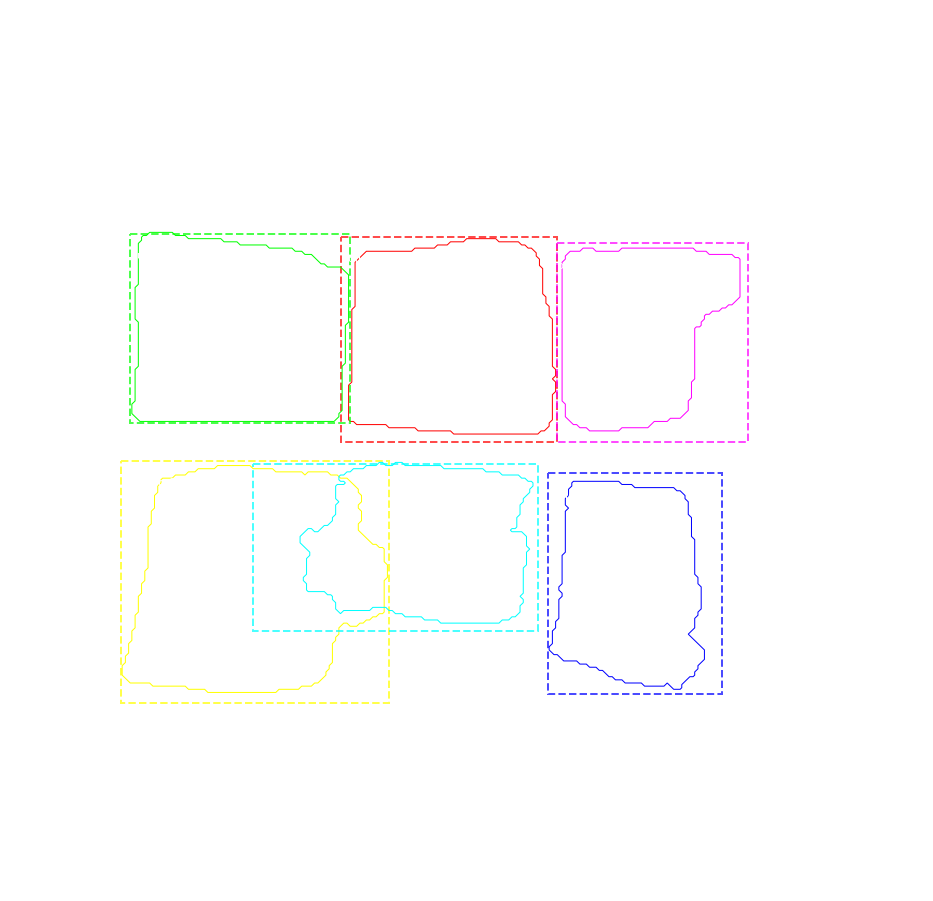

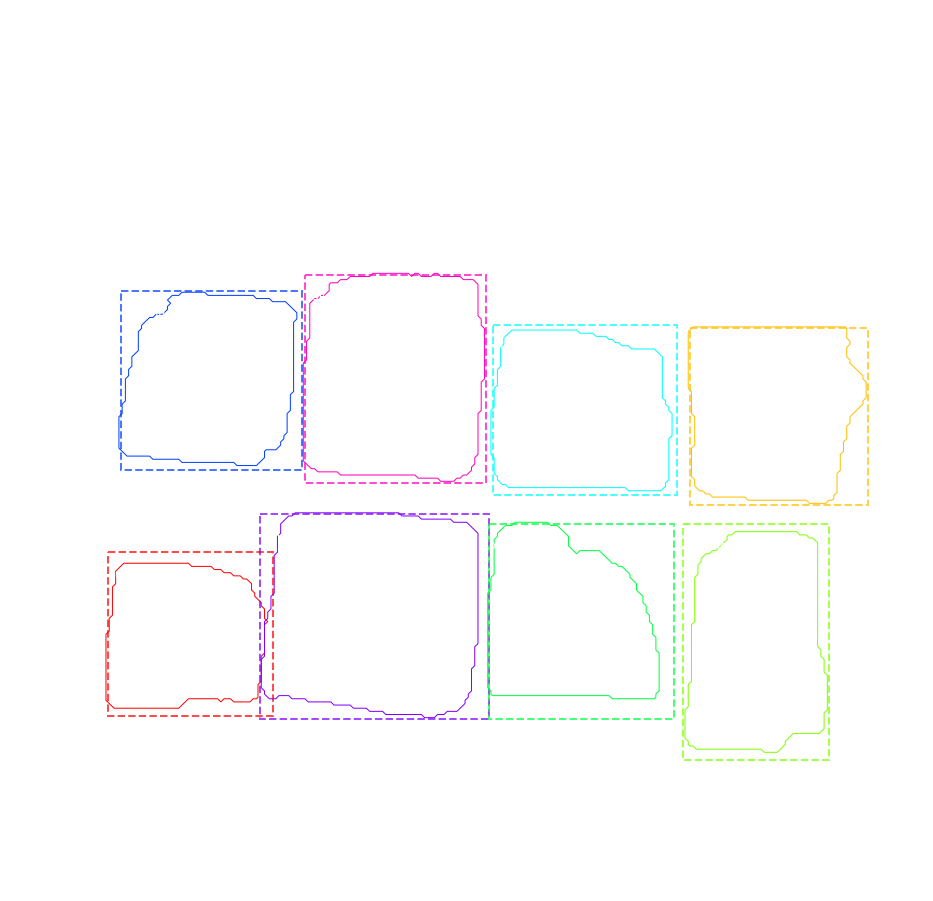

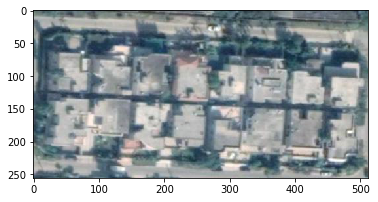

In [7]:
file_name = 'block2'
img_org = skimage.io.imread("./data/test_Data/"+ file_name +".jpg")

org_masks, new_image = getImageData(img_org)

[[324 136]
 [272 132]
 [275  79]
 [327  82]]
256
512


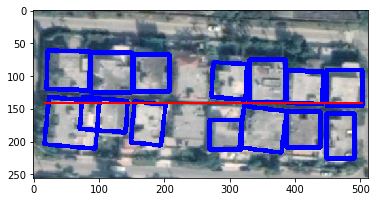

In [27]:
plt.figure()
img_org = skimage.io.imread("./data/test_Data/"+ file_name +".jpg")
print(org_masks[10])
drawMasks(img_org, org_masks)

estimateCenterLineCoords(img_org, org_masks)
plt.imshow(img_org)

In [26]:
def estimateCenterLineCoords(image, masks):
    height, width, _ = image.shape
    print(height)
    print(width)
    
    
    #the image is horizontal, need to consider width angle of each mask to estimate dividing line
    if width > height:
        #get min and max x coordinates and average y
        x_coords = []
        y_coords = []
        for m in masks:
            x_coords.append(m[0][0])
            x_coords.append(m[1][0])
            x_coords.append(m[2][0])
            x_coords.append(m[3][0])
            
            y_coords.append(m[0][1])
            y_coords.append(m[1][1])
            y_coords.append(m[2][1])
            y_coords.append(m[3][1])
        
        average_y = int(sum(y_coords) / len(y_coords))
        
        a = (min(x_coords), average_y)
        b = (max(x_coords), average_y)
        
        cv2.line(image,a,b,(255,0,0),2)

    #the image is vertical, need to consider height angle of each mask to estimate dividing line
    elif width < height:
        print("none")
        

In [ ]:
def adjustCenterLineCoords(image, masks, a, b):
    

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  148.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  320.00000  float64
anchors                  shape: (1, 25575, 4)         min:   -1.13492  max:    1.93429  float32


/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  320.00000  float64
anchors                  shape: (1, 25575, 4)         min:   -1.13492  max:    1.93429  float32


/usr/local/lib/python3.5/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


47
426
384
342
300
258
216
174
132
90
48
Cost before line adjustment: 
142
Cost After line adjustment: 
0
[406, 360, 300, 258, 210, 153, 101, 48]


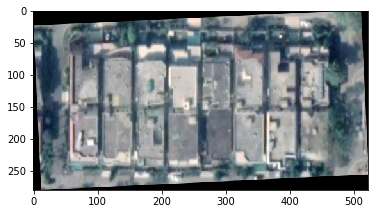

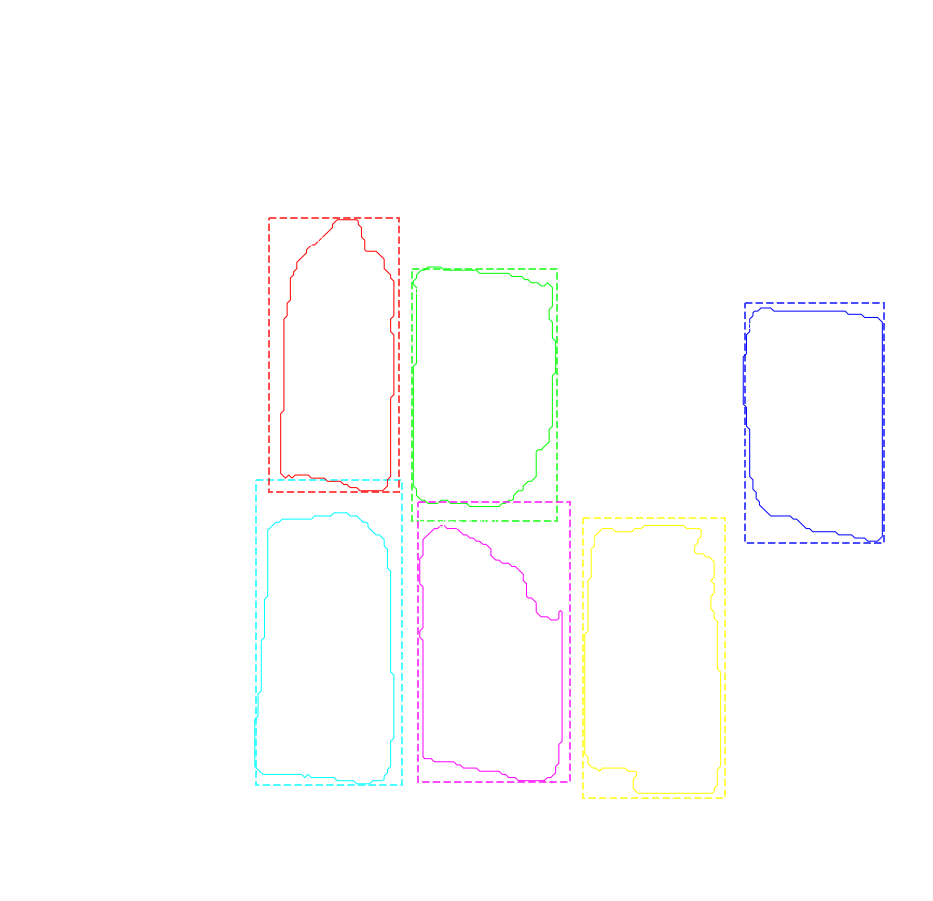

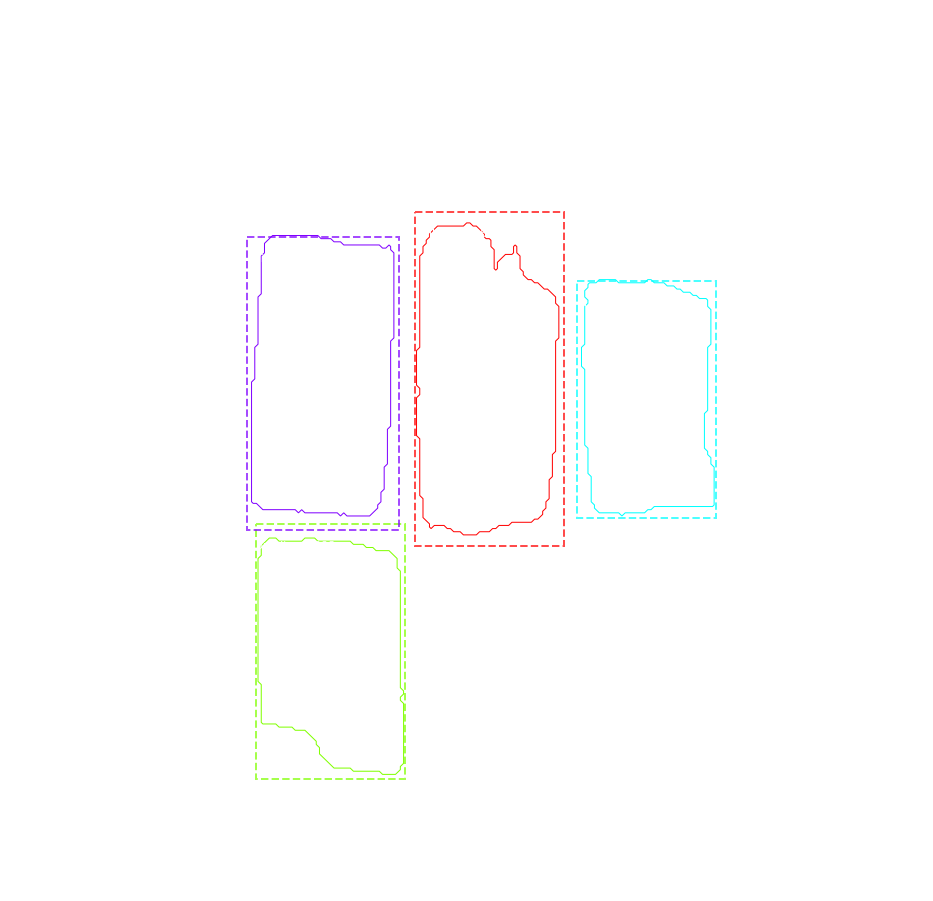

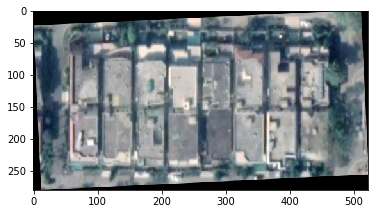

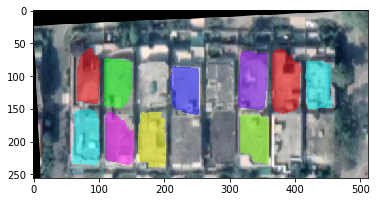

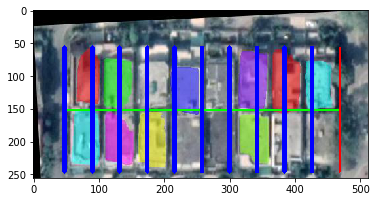

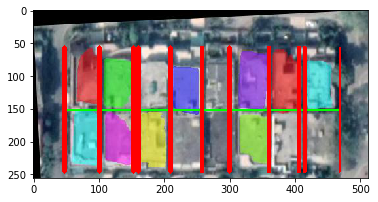

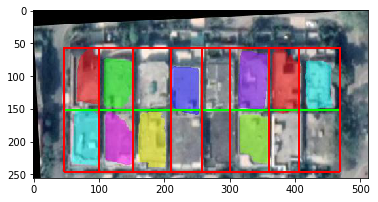

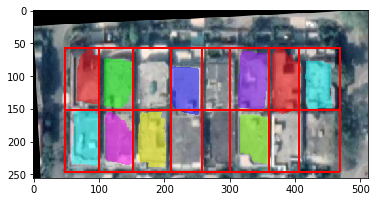

In [5]:
a = (130, 470)
b = (150, 50)

r_image, a, b, rotation_angle = getRotatedImageAndDividingLine(img_org, a, b)
w, l, masks, r_image = getRotatedImageData(r_image, file_name)

grid_boxes = estimateGrid(file_name, r_image, w, l, masks, a, b)


#generate Masks
for box in grid_boxes:
    cv2.line(r_image,box[0],box[1],(255,0,0),2)
    cv2.line(r_image,box[1],box[2],(255,0,0),2)
    cv2.line(r_image,box[2],box[3],(255,0,0),2)
    cv2.line(r_image,box[3],box[0],(255,0,0),2)
    
plt.figure()
plt.imshow(r_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


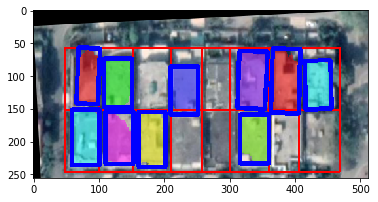

In [8]:
drawMasks(r_image, masks)
plt.imshow(r_image)

# Validation

In [6]:
annFile='./annotations/ground_truth_coco.json'
coco=COCO(annFile)

cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(' '.join(nms)))

catIds = coco.getCatIds(catNms=['building'])
imgIds = coco.getImgIds(catIds=catIds );
print(imgIds)
imgIds = coco.getImgIds(imgIds = [1])
ann_img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]

annIds = coco.getAnnIds(imgIds=ann_img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)

print(anns)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
COCO categories: 
building

COCO supercategories: 
building
[1]
[{'id': 1, 'image_id': 1, 'segmentation': [[56, 54, 54, 99, 150, 104, 151, 57]], 'area': 4850, 'iscrowd': 0, 'category_id': 1, 'bbox': [54, 54, 97, 50]}, {'id': 2, 'image_id': 1, 'segmentation': [[158, 60, 155, 102, 230, 108, 236, 64]], 'area': 3888, 'iscrowd': 0, 'category_id': 1, 'bbox': [155, 60, 81, 48]}, {'id': 3, 'image_id': 1, 'segmentation': [[52, 105, 52, 149, 147, 156, 150, 112]], 'area': 4998, 'iscrowd': 0, 'category_id': 1, 'bbox': [52, 105, 98, 51]}, {'id': 4, 'image_id': 1, 'segmentation': [[154, 113, 152, 153, 241, 157, 245, 115]], 'area': 4092, 'iscrowd': 0, 'category_id': 1, 'bbox': [152, 113, 93, 44]}, {'id': 5, 'image_id': 1, 'segmentation': [[49, 158, 48, 199, 146, 205, 149, 162]], 'area': 4747, 'iscrowd': 0, 'category_id': 1, 'bbox': [48, 158, 101, 47]}, {'id': 6, 'image_id': 1, 'segmentation': [[153, 163, 150, 205, 237,

[155, 60, 81, 48]
[409  58 464 153]
[406  57 468 152]
0.8715596330275229


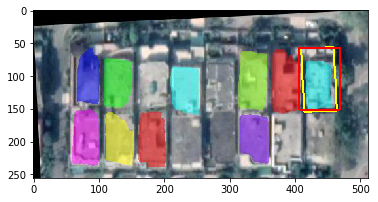

In [7]:
test_img = skimage.io.imread("./rotated_results/"+ file_name +".jpg")

I = skimage.io.imread(os.path.join(ROOT_DIR, "annotations" ,ann_img['file_name']))
bbox = getBoundingBoxCoordinates(anns[0]['bbox'])
print(anns[1]['bbox'])


r_bbox = rotatebbox(img_org, rotation_angle, bbox)


cv2.line(test_img,r_bbox[0],r_bbox[1],(255,255,0),2)
cv2.line(test_img,r_bbox[1],r_bbox[2],(255,255,0),2)
cv2.line(test_img,r_bbox[2],r_bbox[3],(255,255,0),2)
cv2.line(test_img,r_bbox[3],r_bbox[0],(255,255,0),2)

pred_bbox = grid_boxes[1]
cv2.line(test_img,pred_bbox[0],pred_bbox[1],(255,0,0),2)
cv2.line(test_img,pred_bbox[1],pred_bbox[2],(255,0,0),2)
cv2.line(test_img,pred_bbox[2],pred_bbox[3],(255,0,0),2)
cv2.line(test_img,pred_bbox[3],pred_bbox[0],(255,0,0),2)


r_bbox = np.array([list(min(r_bbox)), list(max(r_bbox))]).flatten()
pred_bbox = np.array([list(min(pred_bbox)), list(max(pred_bbox))]).flatten()

print(r_bbox)
print(pred_bbox)

iou = bb_intersection_over_union(r_bbox, pred_bbox)


print(iou)
plt.figure()
plt.imshow(test_img)

(437, 199)
0.70843776106934
(437, 104)
0.8715596330275229
(383, 199)
0.8219289340101523
(383, 104)
0.7937477542220626
(330, 199)
0.7896462467644522
(330, 104)
0.8384970336189849
(279, 199)
0.7549949545913219
(279, 104)
0.7226890756302521
(234, 199)
0.8149720239243681
(234, 104)
0.784
(181, 199)
0.8436505129112133
(181, 104)
0.8810333106730116
(127, 199)
0.8950297447706774
(127, 104)
0.8396039603960396
(74, 199)
0.8584440227703984
(74, 104)
0.8854633446854275


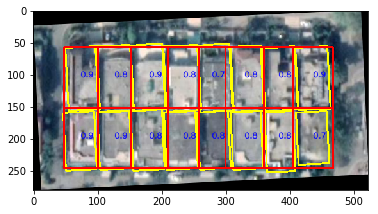

In [8]:
def writeIOU(image, point, text):
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontScale = 0.4
    color = (0, 0, 255)
    thickness = 1
    cv2.putText(image, text, point, font, fontScale, color, thickness, cv2.LINE_AA)


img = rotate_bound(img_org, -1*rotation_angle)

for ann in anns:
    ann_bbox = getBoundingBoxCoordinates(ann['bbox'])
    r_bbox = rotatebbox(img_org, rotation_angle, ann_bbox)
        
    cv2.line(img,r_bbox[0],r_bbox[1],(255,255,0),2)
    cv2.line(img,r_bbox[1],r_bbox[2],(255,255,0),2)
    cv2.line(img,r_bbox[2],r_bbox[3],(255,255,0),2)
    cv2.line(img,r_bbox[3],r_bbox[0],(255,255,0),2)
    

for box in grid_boxes:
    iou_arr = []
    pred_bbox = box
        
    cv2.line(img,pred_bbox[0],pred_bbox[1],(255,0,0),2)
    cv2.line(img,pred_bbox[1],pred_bbox[2],(255,0,0),2)
    cv2.line(img,pred_bbox[2],pred_bbox[3],(255,0,0),2)
    cv2.line(img,pred_bbox[3],pred_bbox[0],(255,0,0),2)
    
    pred_bbox = np.array([list(min(pred_bbox)), list(max(pred_bbox))]).flatten()
    
    for ann in anns:
        ann_bbox = getBoundingBoxCoordinates(ann['bbox'])
        r_bbox = rotatebbox(img_org, rotation_angle, ann_bbox)
        r_bbox = np.array([list(min(r_bbox)), list(max(r_bbox))]).flatten()
        
        iou_arr.append(bb_intersection_over_union(r_bbox, pred_bbox))
        
    iou = max(iou_arr)
    
    
    point = (int(pred_bbox[0] + (pred_bbox[2] - pred_bbox[0])/2), int(pred_bbox[1] + (pred_bbox[3] - pred_bbox[1])/2))
    print(point)
    
    print(iou)
    
    writeIOU(img, point, str(round(iou,1)))

plt.imshow(img)
    